# Welcome to CSE 276F, Assignment 2

In assignment 2, we will leverage the power of neural networks in two different ways to tackle robotics tasks. We will again be using the [ManiSkill simulator](https://github.com/haosulab/ManiSkill) for this assignment.

Neural networks provide a general purpose way to ingest large amounts of data to then predict some target distribution of labels. One way to use it is to build computer vision systems to predict object poses followed by motion planning in real robotics. Another more recently popular way is to train via imitation learning end-to-end robotics policies to control robots directly with neural networks instead of motion planning.

## Setup Code / Packages

If you are running code locally follow the installation instructions for ManiSkill here: https://maniskill.readthedocs.io/en/latest/user_guide/getting_started/installation.html. You will need a CUDA-enabled GPU on a Linux machine for assignments. Windows/Mac have more limited support but are useful if that is the local machine you have access to for local debugging. When building custom environments you can then use a GUI to explore environments which helps the development process.

If you are using UCSD Datahub you don't need to do any additional installation steps. You only need to run `pip install --upgrade mani_skill-nightly`

If you are using Google Colab make sure to run the two cells below to install all dependencies.

If you see an error such as

`ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject`

simply restart the notebook after running the installation commands.

In [ ]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev
# dependencies
!pip install --upgrade mani_skill-nightly

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libvulkan1
Recommended packages:
  mesa-vulkan-drivers | vulkan-icd
The following NEW packages will be installed:
  libvulkan-dev libvulkan1
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,020 kB of archives.
After this operation, 17.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan1 amd64 1.3.204.1-2 [128 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libvulkan-dev amd64 1.3.204.1-2 [892 kB]
Fetched 1,020 kB in 1s (1,301 kB/s)
Selecting previously unselected package libvulkan1:amd64.
(Reading database ... 126101 files and directories currently installed.)
Preparing to unpack .../libvulkan1_1.3.204.1-2_amd64.deb ...
Unpacking libvulkan1:amd64 (1.3.204.1-2) ...
Selecting previously unselected package libvulkan-dev:amd64.
Preparing to un

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

# 1 Computer Vision with Simulation (9 pts)

In assignment 1 we solved tasks with ground truth information about where objects were. This time we will try and solve them purely through vision via  pose estimation and motion planning. Thankfully with simulation we can both generate our training data and verify our trained pose estimation models.

We will first try and use RGB data alone for a single task and overfit a pose estimation model onto that task's data. This means we are also using `obs_mode="rgb"` now which means ground truth data is not returned by the gym environment, only robot propioceptive data and vision data. The data itself looks like below

Dict('agent': Dict('qpos': Box(-inf, inf, (16, 9), float32), 'qvel': Box(-inf, inf, (16, 9), float32)), 'extra': Dict('is_grasped': Box(False, True, (16,), bool), 'tcp_pose': Box(-inf, inf, (16, 7), float32), 'goal_pos': Box(-inf, inf, (16, 3), float32)), 'sensor_param': Dict('base_camera': Dict('extrinsic_cv': Box(-inf, inf, (16, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (16, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (16, 3, 3), float32))), 'sensor_data': Dict('base_camera': Dict('rgb': Box(0, 255, (16, 128, 128, 3), uint8))))


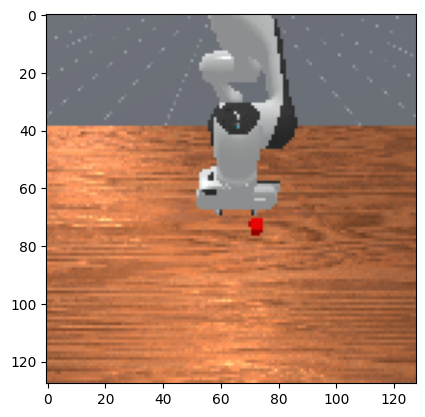

In [1]:
import mani_skill
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
# we will use parallel environments to speed up data generation for training
env = gym.make("PickCube-v1", num_envs=16, obs_mode="rgb", render_mode="rgb_array", enable_shadow=True)
obs, _ = env.reset()

# print below the observation space
print(env.observation_space)
# show an example image
plt.imshow(obs["sensor_data"]["base_camera"]["rgb"].cpu().numpy()[0])

## Problem 1.1: Generate your Pose Estimation Dataset (3 pts)

We will use our simulation tools first to generate a dataset for pose estimation training. Note that the ground truth object pose is stored in `env.unwrapped.cube.pose`, use that to create a torch Dataset class below.

You may want to think about the representation of pose data as well, you may find some are easier to predict accurately than others. Knowing that you are only predicting a cube's pose can help as well.

In this sub-section your task is to create the torch Dataset class to hold the image and pose data. The `__getitem__` function should return data with any necessary transformations already applied. Then in the next section explain the decision behind any data transformations you performed and/or representations chosen.

In [ ]:
import mani_skill
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset

num_envs = 128
total_samples = 1024
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgb", render_mode="rgb_array", enable_shadow=True)

### your code goes below ###
images = [] # your inputs
poses = [] # your labels
samples = 0

while samples < total_samples:
    obs, _ = env.reset()
    samples += num_envs
    # note that for obs data images are not cloned by default so make sure to clone it before inserting into dataset


class RGBPoseEstimationDataset(Dataset):
    def __init__(self, images, poses):
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass

dataset = RGBPoseEstimationDataset(torch.cat(images), torch.cat(poses))
### your code goes above ###

In [ ]:
# fill the string below with your response to the following:
# "Detail why you chose your particular rgb/pose representation and any transformations performed on that data. Explain why you perform those transformations"
P1_1_ANSWER = ""

## Problem 1.2: Create and Train a Neural Net based Pose Estimation Model (3 pts)

Next up is to train a small 2D conv-net based model to predict the cube pose using the dataset you constructed earlier.

Points given here will be based on the code and checking that it mostly makes sense. We verify if it is accurate enough with problem 1.3 when running motion planning to solve the pick cube task. Note that your rotation estimation does not need to be super accurate, it is a bit difficult to estimate from RGB alone due to the low resolutions.

In [ ]:
import torch
import torch.nn as nn

class PoseEstimator(nn.Module):
    def __init__(self):
        super().__init__()
        ### your code goes below ###
        pass
        ### your code goes above ###
    def forward(self, x):
        ### your code goes below ###
        pass
        ### your code goes above ###

In [ ]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
device = torch.device("cuda")
model = PoseEstimator()
model.to(device)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### your code goes below ###

### your code goes above ###

## Problem 1.3: Pick up Objects from Vision (3 pts)

Using your trained model from above combined with motion planning, grasp the cube from vision inputs only and bring it to the green goal which is at position `goal_pos`. An 80% success rate minimum is required to pass this section.

Note that you only really need accurate position estimation. If your rotation estimate is not perfect that is fine, you can still easily pick up the cube.

In [ ]:
### setup code, don't change! ###
import mani_skill.envs
import gymnasium as gym
import numpy as np
from mani_skill.utils.visualization import images_to_video
from mani_skill.utils.wrappers.record import RecordEpisode
import mplib
from tqdm.notebook import tqdm
from transforms3d.euler import euler2quat, quat2euler
def create_env():
    env = gym.make("PickCube-v1",
                num_envs=1,
                obs_mode="rgb",
                control_mode="pd_joint_pos",
                render_mode="rgb_array",
                reward_mode="none",
                human_render_camera_configs=dict(shader_pack="default")
    )
    env = RecordEpisode(env, output_dir="pick_cube_mp", video_fps=20, info_on_video=False, save_trajectory=False)
    env.reset(seed=42)
    return env
env = create_env()
robot = env.unwrapped.agent.robot
link_names = [link.get_name() for link in robot.get_links()]
joint_names = [joint.get_name() for joint in robot.get_active_joints()]
planner = mplib.Planner(
    urdf=env.unwrapped.agent.urdf_path,
    srdf=env.unwrapped.agent.urdf_path.replace(".urdf", ".srdf"),
    user_link_names=link_names,
    user_joint_names=joint_names,
    move_group="panda_hand_tcp",
    # ensures planned motions do not exceed these limits
    joint_vel_limits=np.ones(7) * 0.8,
    joint_acc_limits=np.ones(7) * 0.8,
)
# this sets the planner object up such that you can plan with poses in the world frame, which is the default frame of all pose data
# in our simulator
planner.set_base_pose(np.concatenate([robot.pose.sp.p, robot.pose.sp.q]))

In [ ]:
EPISODES = 10

def pick_cube_mp_solution(env, obs, goal_pos, model):
    robot = env.unwrapped.agent.robot
    panda_hand_tcp = env.unwrapped.agent.robot.links_map["panda_hand_tcp"]

    ### your code goes below ###
    # you can only use data in the obs variable given and goal position, no ground truth permitted!

    # # example use of the motion planner
    result = planner.plan_screw(
        np.concatenate([panda_hand_tcp.pose.p[0].numpy() + np.array([0, 0, 0.2]), panda_hand_tcp.pose.q[0].numpy()]),
        robot.qpos.cpu().numpy()[0],
        time_step=env.unwrapped.control_timestep,
    )
    # follow the generated plan while keeping the gripper open (1)
    for pos in result["position"]:
        env.step(np.concatenate([pos, [1]]))

    ### your code goes above ###

### evaluation code below ###
successes = 0
env = create_env()
for i in tqdm(range(EPISODES)):
    obs, _ = env.reset(seed=i)
    goal_pos = obs["extra"]["goal_pos"].cpu().numpy()[0]
    pick_cube_mp_solution(env, obs, goal_pos, model)
    success = env.get_info()["success"].item()
    successes += success
env.reset()
print(f"Success rate: {successes/EPISODES}")
if successes/EPISODES < 0.8:
    print("Success rate < 80%. You may need to tune your motion planner or train a better pose estimation model")

In [ ]:
from IPython.display import Video
Video("./pick_cube_mp/0.mp4", embed=True, width=640) # Watch our replay

# 2 Imitation Learning (7 pts)

We will take our first dive into end-to-end neural net powered robotics models via imitation learning. Imitation learning is the process of learning the behavior exhibited in some dataset of demonstrations. Via ManiSkill we provide a ton of various demonstration data for different tasks. Your goal in this section is to use Behavior Cloning to imitate a simple [cube pushing task](https://maniskill.readthedocs.io/en/latest/tasks/table_top_gripper/index.html#pushcube-v1) with the `pd_joint_delta_pos` controller and solve it.

First we will download our demonstration dataset and pre-process it to fill it up with state-based observation data and action labels. Then we will show some example code to load that data and inspect it.

In [ ]:
!python -m mani_skill.utils.download_demo PushCube-v1
!python -m mani_skill.trajectory.replay_trajectory \
  --traj-path ~/.maniskill/demos/PushCube-v1/motionplanning/trajectory.h5 \
  --use-first-env-state -c pd_joint_delta_pos -o state \
  --save-traj --num-envs 2 -b physx_cpu --count 100

In [ ]:
import h5py
import json
from mani_skill.utils.io_utils import load_json
def load_h5_data(data):
    out = dict()
    for k in data.keys():
        if isinstance(data[k], h5py.Dataset):
            out[k] = data[k][:]
        else:
            out[k] = load_h5_data(data[k])
    return out
# load the dataset and metadata
dataset_file = "/root/.maniskill/demos/PushCube-v1/motionplanning/trajectory.state.pd_joint_delta_pos.physx_cpu.h5" # change this if needed
data = h5py.File(dataset_file, "r")
json_path = dataset_file.replace(".h5", ".json")
json_data = load_json(json_path)
# trajectories by default are labeled traj_i for i in 0 to ...
for k in data.keys():
    print("Trajectory key", k)
    # load h5 data to numpy with the load_h5_data function
    trajectory = load_h5_data(data[k])
    print("Trajectory data fields and shapes:")
    for k, v in trajectory.items():
        if not isinstance(v, dict):
            print("-", k, v.shape)
    break

Trajectory key traj_0
Trajectory data fields and shapes:
- obs (72, 35)
- actions (71, 8)
- terminated (71,)
- truncated (71,)
- success (71,)


For imitation learning work/research, you typically want to ensure that the data collection environment is the same environment you evaluate your models on. All ManiSkill demonstrations will provide in the json metadata `json_data["env_info"]` object which tells you how to reconstruct the exact environment the data was collected from. The code below does that for example. Note that it will automatically set the appropriate observation and control modes that match the data (e.g. the observation data has the same number of dimensions as the dataset)

In [ ]:
import gymnasium as gym
from mani_skill.vector.wrappers.gymnasium import ManiSkillVectorEnv
from mani_skill.utils.wrappers.record import RecordEpisode
from collections import defaultdict
import torch
def create_eval_envs(json_data, num_envs=16, max_episode_steps=100, video_path=None):
    env_info = json_data["env_info"]
    env_id = env_info["env_id"]
    env_kwargs = env_info["env_kwargs"]
    if "num_envs" in env_kwargs: env_kwargs.pop("num_envs")
    if "sim_backend" in env_kwargs: env_kwargs.pop("sim_backend")
    num_eval_envs = num_envs
    # the keen eye might notice that we are using the gpu sim backend instead
    # of the physx_cpu backend despite our data being collected and replayed on the physx_cpu backend
    # for some tasks and control modes this discrepancy is okay. This is done to make evals faster for the
    # purpose of this assignment.
    eval_envs = gym.make(env_id, num_envs=num_eval_envs, reconfiguration_freq=1, max_episode_steps=max_episode_steps, **env_kwargs)
    if video_path is not None:
        eval_envs = RecordEpisode(eval_envs, output_dir=video_path, save_trajectory=False, max_steps_per_video=max_episode_steps)
    eval_envs = ManiSkillVectorEnv(eval_envs, ignore_terminations=True, record_metrics=True)
    return eval_envs

def eval_policy(eval_envs, actor, verbose=1):
    # evaluation loop, which will record metrics for each episode
    obs, _ = eval_envs.reset()
    eval_metrics = defaultdict(list)
    while True:
        action = actor(obs)
        obs, rew, terminated, truncated, info = eval_envs.step(action)
        # note as there are no partial resets, truncated is True for all environments at the same time
        if truncated.any():
            for k, v in info["final_info"]["episode"].items():
                eval_metrics[k].append(v.float())
            break
    if verbose:
        for k in eval_metrics.keys():
            print(f"{k}_mean: {torch.mean(torch.stack(eval_metrics[k])).item()}")
    return eval_metrics

## Problem 2.1: State based Behavior Cloning (5 pt)

With the setup out of the way, we will now proceed to training a state-based policy via behavior cloning on the dataset.

You will need to create a torch Dataset like before, but this time your modeling problem is to predict actions from observations. After creating the dataset you then need to train a small neural network (MLP based) for this problem.

Note that the dataset contains per trajectory `N` actions and `N+1` observations. They are ordered such that action `i` is the action taken after observing observation `i`, and observation `i+1` is what is observed after taking that action.

We provide some starter code below that you can fill in.

In [ ]:
### Create your dataset ###
import mani_skill
import gymnasium as gym
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset

### your code goes below ###
class TrajectoryDataset(Dataset):
    def __init__(self, data, json_data):
        # write code to save and store the data. You probably also want to save it to the cuda device
        pass

    def __len__(self):
        pass

    def __getitem__(self, idx):
        # should return observation i and action i
        pass

### your code goes above ###

dataset_file = "/root/.maniskill/demos/PushCube-v1/motionplanning/trajectory.state.pd_joint_delta_pos.physx_cpu.h5" # change this if needed
data = h5py.File(dataset_file, "r")
json_path = dataset_file.replace(".h5", ".json")
json_data = load_json(json_path)
dataset = TrajectoryDataset(data, json_data)

In [ ]:
### Create your model ###
import torch
import torch.nn as nn
class Actor(nn.Module):
    def __init__(self, sample_obs, sample_act):
        super().__init__()
        ### your code goes below ###
        # use sample_obs and sample_act to determine the input and output shape of your model
        # we recommend starting with a small basic MLP, and experimenting with different aspects of the architecture
        pass
        ### your code goes above ###
    def forward(self, x):
        ### your code goes below ###
        pass
        ### your code goes above ###

### evaluation code ###
device = torch.device("cuda")
eval_envs = create_eval_envs(json_data, num_envs=16)
sample_obs, _ = eval_envs.reset()
sample_act = eval_envs.action_space.sample()
actor = Actor(sample_obs, sample_act).to(device)
actions = actor(sample_obs)
assert actions.shape[1] == 8 and actions.shape[0] > 0, "actions should be batched and of shape (B, 8), 7 DOF joint position control + 1 DOF gripper"
eval_envs.close()
### evaluation code ###

2025-05-04 07:47:35,723 - mani_skill  - WARNING - shader_dir argument will be deprecated after ManiSkill v3.0.0 official release. Please use sensor_configs/human_render_camera_configs to set shaders.


In [ ]:
### Train your model ###
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
device = torch.device("cuda")
torch.manual_seed(0)
np.random.seed(0)
eval_envs = create_eval_envs(json_data, num_envs=16, max_episode_steps=100)
sample_obs, _ = eval_envs.reset(seed=0)
sample_act = eval_envs.action_space.sample()
actor = Actor(sample_obs, sample_act).to(device)
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### your code goes below ###
# train your actor policy to predict the actions in the dataset. You can use MSE loss.
# make sure to run the eval_policy function every once in a while to track training progress
# and save your best policy checkpoint locally to be loaded later for evaluation.
# A minimum 50% success_once_mean rate over 64 trials is required for full points.
# if you are confident your solution is probably correct, sometimes a different seed can work. Only one seed needs to work for the assignment
# training should not need to take more than 2-3 minutes on google colab.



In [ ]:
torch.manual_seed(0)
np.random.seed(0)
eval_envs = create_eval_envs(json_data, num_envs=16, max_episode_steps=100, video_path="pushcube_il_eval/")
sample_obs, _ = eval_envs.reset(seed=0)
sample_act = eval_envs.action_space.sample()
actor = Actor(sample_obs, sample_act).to(device)

### load your best checkpoint below ###
state_dict = torch.load("best_policy.ckpt")
actor.load_state_dict(state_dict)
### load your best checkpoint above ###

### evaluation code ###
from tqdm.notebook import tqdm
success_rate = []
for _ in tqdm(range(4)):
    eval_metrics = eval_policy(eval_envs, actor, verbose=0)
    val = torch.mean(torch.stack(eval_metrics["success_once"])).item()
    success_rate.append(val)
print(f"Success rate: {np.mean(success_rate)}")
if np.mean(success_rate) < 0.5:
    print("Success rate is less than 50%! You need to try and tune your training a bit more or pick a better policy")
eval_envs.close()
from IPython.display import Video
Video("./pushcube_il_eval/0.mp4", embed=True, width=640) # Watch our replay
### evaluation code ###

## Problem 2.2 (1 pt)

In 2.1 we ask you to evaluate the policy in the environment itself. Briefly describe in 1-2 sentences why we can't simply use the loss function to determine policy performance below

In [ ]:
P2_2_ANSWER = ""

## Problem 2.3 (1 pt)

Compare and contrast sense-plan-act style methods as done in part 1 and assignment 1 compared to more end-to-end approaches like imitation learning in terms of how training differs. Is training one inherently more difficult than another? What are data requirements like?

In [ ]:
P2_3_ANSWER = ""

## 2.4 Extra

In the future assignments we will not go too deep into more advanced imitation learning methods like Diffusion Policy or training proper Vision Language Action models. We recommend checking out the imitation learning code/baselines in the [ManiSkill](https://github.com/haosulab/ManiSkill/) repository as well as trying out the [Hugging Face LeRobot](https://github.com/huggingface/lerobot) library which provides tools for real world imitation learning and reinforcement learning.



# 3 Submission

If you are taking the CSE 276F course at UC San Diego, to submit your work please save this .ipynb file locally first. Then run the cells below which zips up some of your answers and generated evaluation images/videos for grading. Submit the .tar.gz file and your .ipynb file.

In [ ]:
work_data = {
    "p1_1": P1_1_ANSWER,
    "p2_2": P2_2_ANSWER,
    "p2_3": P2_3_ANSWER
}
import json
with open("answers.json", 'w') as json_file:
    json.dump(work_data, json_file, indent=2)

In [ ]:
!mkdir -p hw_files/p1.3 2> /dev/null
!mkdir -p hw_files/p2.1 2> /dev/null
!cp answers.json hw_files/
!cp pick_cube_mp/*.mp4 hw_files/p1.3
!cp pushcube_il_eval/*.mp4 hw_files/p2.1
!tar -czvf hw_files.tar.gz hw_files > /dev/null